# Getting Started With Our Analysis

### Loading in the saved dataset and our tools:
So, to get started we're going to pull the pkl file that I saved our last dataset to - the one that we cleaned up and truncated down. It's still a pretty hefty 21K rows, so we've still got plenty to play with this time.

We're basically going to make use of the same tools this time, except we're also going to bring in statsmodels to run quick OLS tests on variations of our final model. Let's get started.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.formula.api import ols

In [4]:
df = pd.read_csv('df_cleaned.csv')
df.head()

,Unnamed: 0,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,7129300520,2014-10-13,221900.0,3.0,1.00,1180,5650,1.0,0.0,...,7,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,1,6414100192,2014-12-09,538000.0,3.0,2.25,2570,7242,2.0,0.0,...,7,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,2,5631500400,2015-02-25,180000.0,2.0,1.00,770,10000,1.0,0.0,...,6,770,0.0,1933,0.0,98028,47.7379,-122.233,2720,8062
3,3,2487200875,2014-12-09,604000.0,4.0,3.00,1960,5000,1.0,0.0,...,7,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,4,1954400510,2015-02-18,510000.0,3.0,2.00,1680,8080,1.0,0.0,...,8,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503


In [5]:
df.drop('Unnamed: 0', axis = 1, inplace = True)
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,2014-10-13,221900.0,3.0,1.00,1180,5650,1.0,0.0,0.0,...,7,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,2014-12-09,538000.0,3.0,2.25,2570,7242,2.0,0.0,0.0,...,7,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2015-02-25,180000.0,2.0,1.00,770,10000,1.0,0.0,0.0,...,6,770,0.0,1933,0.0,98028,47.7379,-122.233,2720,8062
3,2487200875,2014-12-09,604000.0,4.0,3.00,1960,5000,1.0,0.0,0.0,...,7,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2015-02-18,510000.0,3.0,2.00,1680,8080,1.0,0.0,0.0,...,8,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503


In [6]:
df['date'] = pd.to_datetime(df.date)
df.dtypes

id                        int64
date             datetime64[ns]
price                   float64
bedrooms                float64
bathrooms               float64
sqft_living               int64
sqft_lot                  int64
floors                  float64
waterfront              float64
view                    float64
condition                 int64
grade                     int64
sqft_above                int64
sqft_basement           float64
yr_built                  int64
yr_renovated            float64
zipcode                   int64
lat                     float64
long                    float64
sqft_living15             int64
sqft_lot15                int64
dtype: object

### Check the data for multicolinearity

Before we can move forward with selecting variables, we want to make sure that we deselect those which highly correlate with each other, as they can introduce unnecessary error into our models and interfere with the way we may seek to answer questions.

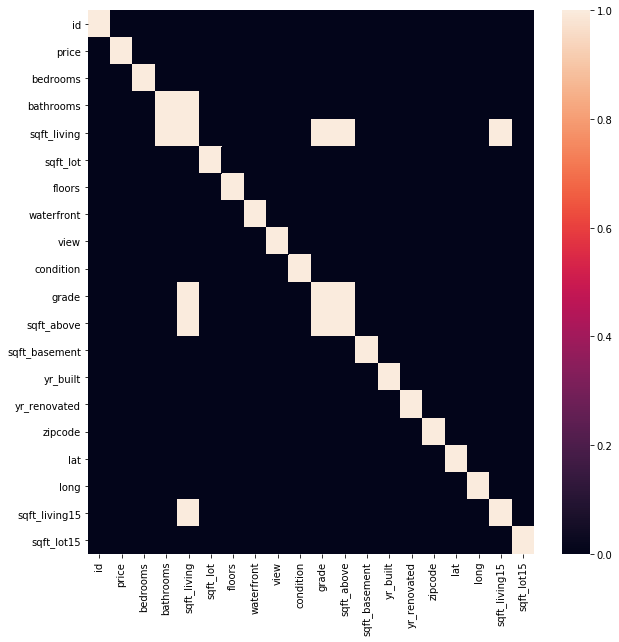

In [25]:
fig = plt.figure(figsize=(10,10))
sns.heatmap(df.corr() > 0.75)

From here, we can see that to stay safe, we're going to assume the following features are colinear with each other:

1. `sqft_living` is colinear with `sqft_living15` and `sqft_above`.
2. `sqft_living` is also colinear with `bathrooms` and `grade`.

This means that once we are running our model, we want to avoid incorporating `sqft_living` with any of those four fields. However, we could combine some of these features since mostly they only highly correlate with `sqft_living`. I'll illustrate below.

Text(0, 0.5, 'sqft_living15')

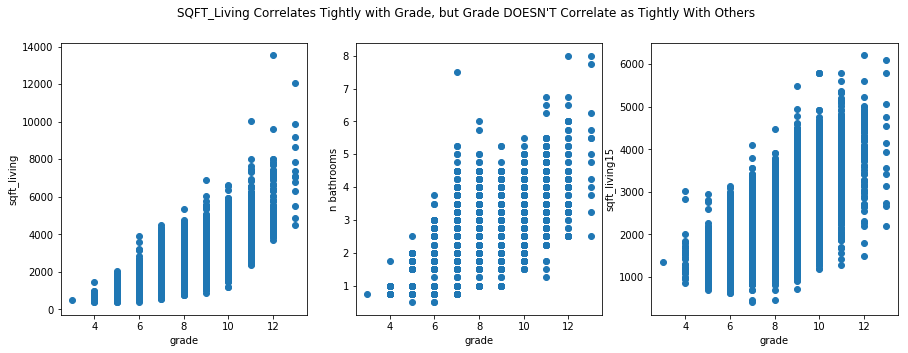

In [52]:
fig = plt.figure(figsize=(15,5))
fig.suptitle("SQFT_Living Correlates Tightly with Grade, but Grade DOESN'T Correlate as Tightly With Others")

ax1 = fig.add_subplot(1,3,1)
ax1.scatter(df.grade, df.sqft_living)
ax1.set_xlabel('grade')
ax1.set_ylabel('sqft_living')

ax2 = fig.add_subplot(1,3,2)
ax2.scatter(df.grade, df.bathrooms)
ax2.set_xlabel('grade')
ax2.set_ylabel('n bathrooms')

ax3 = fig.add_subplot(1,3,3)
ax3.scatter(df.grade, df.sqft_living15)
ax3.set_xlabel('grade')
ax3.set_ylabel('sqft_living15')

### Check the continuous data for normality

Since we're going to be focused on what's going to work well in predicting price, we want to see how close it is to a standard distribution as-is, and see if maybe we want to normalize it from there. We're just going to take a quick look at a histogram of price and its KDE.

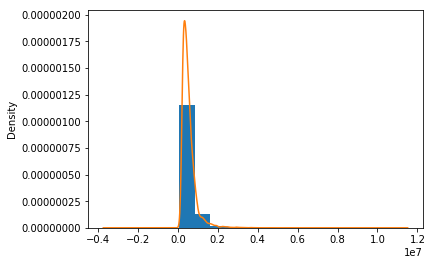

In [8]:
plt.hist(df['price'], density = True)
df['price'].plot.kde()

This is not looking like normally distributed data, so we're going to transform it. Simplest option is always a log transform, as I don't have to load in any extra formulas.

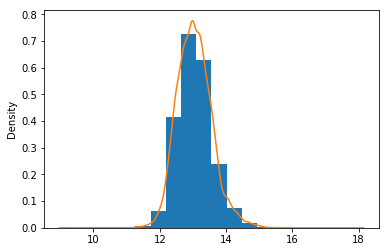

In [9]:
df['pricelog'] = np.log(df['price'])
plt.hist(df['pricelog'], density = True)
df['pricelog'].plot.kde()

Now that `Price` is normally distributed, let's check `sqft_living`.

In [11]:
df['sqft_living'].describe()

count    21054.000000
mean      2082.089864
std        920.578886
min        370.000000
25%       1430.000000
50%       1910.000000
75%       2550.000000
max      13540.000000
Name: sqft_living, dtype: float64

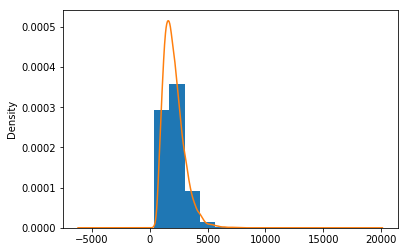

In [12]:
plt.hist(df['sqft_living'], density = True)
df['sqft_living'].plot.kde()

Attempting another log transform on `sqft_living` to see if we can get a more normal distribution out of it as well.

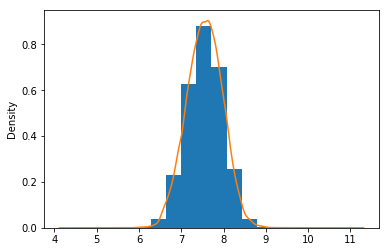

In [13]:
df['sqft_livinglog'] = np.log(df['sqft_living'])
plt.hist(df['sqft_livinglog'], density = True)
df['sqft_livinglog'].plot.kde()

# What Next?

### Geographer's Choice:

Speaking from my background as an educated geographer, I can already tell that location is going to be important in our determination. We're talking about property values, which have been historically tied to cultural values (e.g. which neighborhoods are hot; which neighborhoods are being subsidized; which neighborhoods have been ghettoized; etc) and geographic features.

We need to take a look at our latitude and longitude fields, but first, let's make sure that these sales accurately represent an urban system.

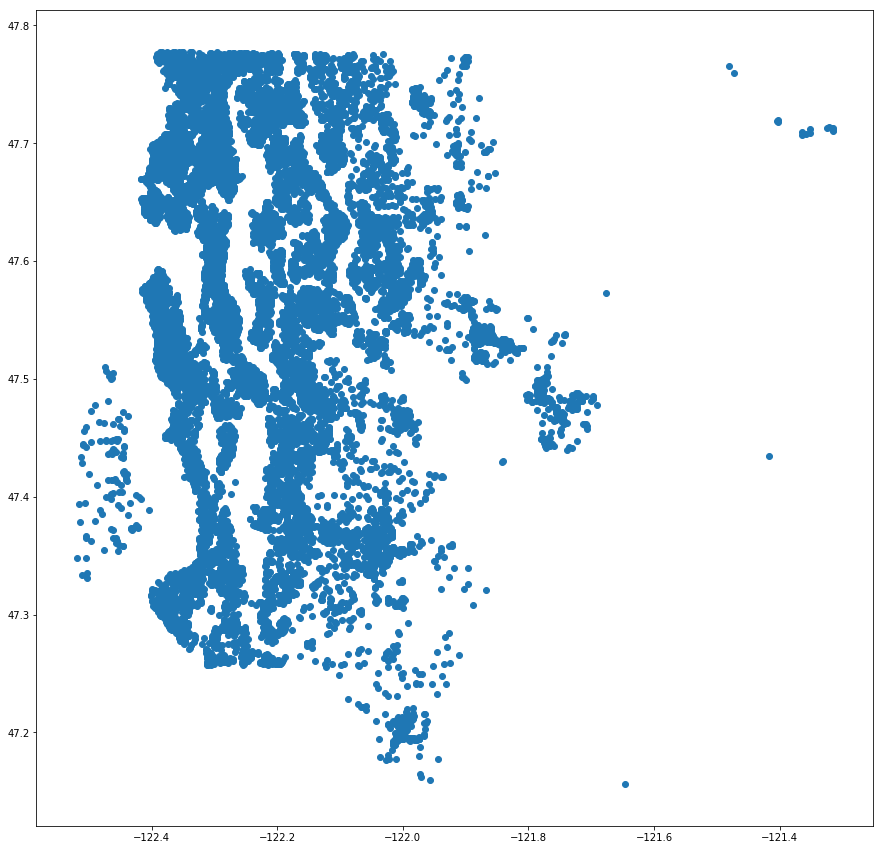

In [14]:
fig = plt.figure(figsize=[15,15])
plt.scatter(df['long'],df['lat'])

![](images/Seattle.png)

From here we can see there's a very clear overlap:  we can see the outline of multiple water features, but also swaths of land that are left 'empty.' These could represent city zoning laws - that is to say, they could be industrial parks or industrial-commercial parks - but at this time, we don't have enough information to know. What we do know is that very plainly, houses are 'clustered' together.

## Should we transform this data?

Transforming the long/lat data will only rob it of its meaning to the context. We can and should use our location data, but there's no reason to transform it when doing so will make it meaningless.

## Getting our bearings again.

From here, we should check out `df.corr` and see what we can pick out next.

In [15]:
df.corr()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,...,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,pricelog,sqft_livinglog
id,1.000000,-0.018183,0.003041,0.003900,-0.013662,-0.132794,0.019030,-0.003792,0.011086,-0.022093,...,-0.005470,0.021251,-0.010933,-0.007295,-0.004350,0.021011,-0.004051,-0.138706,-0.006103,-0.003201
price,-0.018183,1.000000,0.310197,0.526757,0.702790,0.088384,0.255378,0.266549,0.393069,0.036172,...,0.322578,0.053578,0.118673,-0.052655,0.305339,0.021363,0.584449,0.082992,0.891452,0.612008
bedrooms,0.003041,0.310197,1.000000,0.515292,0.579209,0.033277,0.178470,-0.002238,0.078697,0.024718,...,0.298377,0.155592,0.017884,-0.153605,-0.011213,0.131210,0.393725,0.031209,0.344334,0.622572
bathrooms,0.003900,0.526757,0.515292,1.000000,0.755893,0.089415,0.503405,0.064271,0.186356,-0.127350,...,0.279170,0.507556,0.048092,-0.204253,0.023447,0.224609,0.569712,0.088926,0.551478,0.762083
sqft_living,-0.013662,0.702790,0.579209,0.755893,1.000000,0.175048,0.353515,0.105542,0.281639,-0.060849,...,0.430710,0.318392,0.051496,-0.200248,0.051286,0.241386,0.756825,0.185463,0.695856,0.954407
sqft_lot,-0.132794,0.088384,0.033277,0.089415,0.175048,1.000000,-0.006461,0.021831,0.072508,-0.008690,...,0.016874,0.052732,0.005127,-0.130296,-0.086335,0.231066,0.145821,0.722416,0.099299,0.151749
floors,0.019030,0.255378,0.178470,0.503405,0.353515,-0.006461,1.000000,0.020827,0.027113,-0.264980,...,-0.242274,0.489723,0.003511,-0.058612,0.048510,0.125942,0.278872,-0.009957,0.309650,0.367439
waterfront,-0.003792,0.266549,-0.002238,0.064271,0.105542,0.021831,0.020827,1.000000,0.386162,0.016854,...,0.083683,-0.024953,0.073715,0.029433,-0.012347,-0.038160,0.084777,0.030782,0.172735,0.079710
view,0.011086,0.393069,0.078697,0.186356,0.281639,0.072508,0.027113,0.386162,1.000000,0.045265,...,0.271289,-0.055311,0.092124,0.086199,0.006707,-0.078357,0.278246,0.071907,0.344498,0.244295
condition,-0.022093,0.036172,0.024718,-0.127350,-0.060849,-0.008690,-0.264980,0.016854,0.045265,1.000000,...,0.168836,-0.362460,-0.056253,0.003710,-0.015512,-0.106781,-0.092819,-0.003816,0.038458,-0.051468


### Let's take a look at some more intimate data points.

`pricelog` seems to have relationships with `bathrooms`, `bedrooms`, `floors`, and `view`. Let's see what that looks like.

Text(0.5, 1.0, 'viewings')

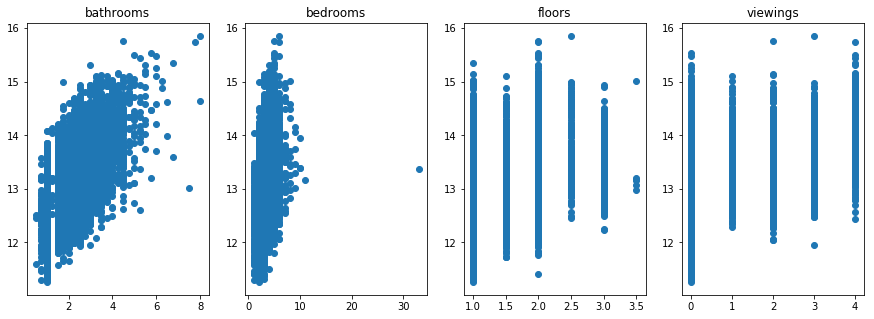

In [16]:
fig = plt.figure(figsize = [15,5])

ax1 = fig.add_subplot(1,4,1)
ax1.scatter(df['bathrooms'],df['pricelog'])
ax1.set_title('bathrooms')

ax2 = fig.add_subplot(1,4,2)
ax2.scatter(df['bedrooms'],df['pricelog'])
ax2.set_title('bedrooms')

ax3 = fig.add_subplot(1,4,3)
ax3.scatter(df['floors'],df['pricelog'])
ax3.set_title('floors')

ax4 = fig.add_subplot(1,4,4)
ax4.scatter(df['view'],df['pricelog'])
ax4.set_title('viewings')

It seems a bit odd that `.corr()` for `grade` and `condition` don't seem to contribute a lot. Let's take a closer look.

Text(0.5, 1.0, 'condition')

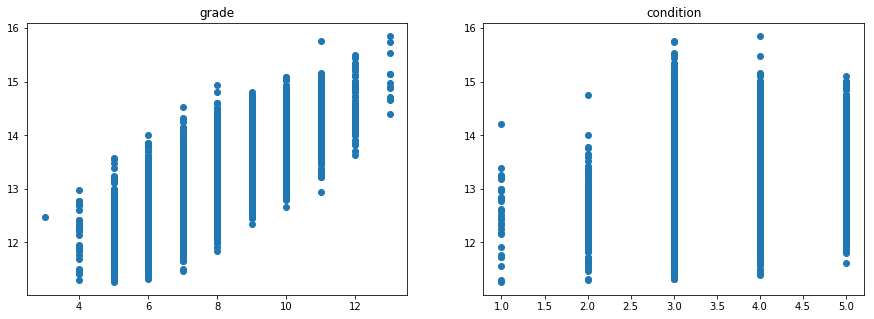

In [17]:
fig = plt.figure(figsize = [15,5])

ax1 = fig.add_subplot(1,2,1)
ax1.scatter(df['grade'],df['pricelog'])
ax1.set_title('grade')

ax2 = fig.add_subplot(1,2,2)
ax2.scatter(df['condition'],df['pricelog'])
ax2.set_title('condition')

Going over some of this `grade` looks useful. `bedrooms` might work out to a stronger fit if we take a look at it a little more closely. 33 bathrooms - this house should be disproportionately large.

In [18]:
df.loc[df['bedrooms']==33]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,pricelog,sqft_livinglog
15856,2402100895,2014-06-25,640000.0,33,1.75,1620,6000,1.0,0.0,0.0,...,580.0,1947,0.0,98103,47.6878,-122.331,1330,4700,13.369223,7.390181


If that's right, given that `sqft_living` is the square footage of the home, then the home must be **mostly bedrooms**, each with only 49sqft of space. I don't think the logistics of all those bedrooms and <2 bathrooms makes sense, do you? This must be a typo. Let's correct it to reflect the median value of bedrooms.

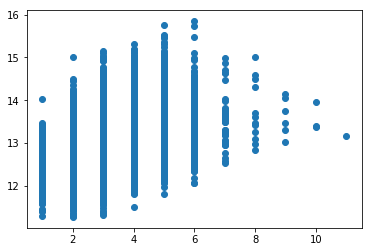

In [19]:
df.loc[df['bedrooms']==33, 'bedrooms'] = df['bedrooms'].median()
plt.scatter(df['bedrooms'],df['pricelog'])

That looks much better. It's correlated, but still very spread out. Let's see if it improved our `.corr()`.

In [20]:
df.corr()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,...,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,pricelog,sqft_livinglog
id,1.000000,-0.018183,0.004313,0.003900,-0.013662,-0.132794,0.019030,-0.003792,0.011086,-0.022093,...,-0.005470,0.021251,-0.010933,-0.007295,-0.004350,0.021011,-0.004051,-0.138706,-0.006103,-0.003201
price,-0.018183,1.000000,0.317586,0.526757,0.702790,0.088384,0.255378,0.266549,0.393069,0.036172,...,0.322578,0.053578,0.118673,-0.052655,0.305339,0.021363,0.584449,0.082992,0.891452,0.612008
bedrooms,0.004313,0.317586,1.000000,0.529022,0.594588,0.034463,0.184414,-0.002162,0.081159,0.021490,...,0.304844,0.160801,0.018636,-0.158214,-0.012947,0.135825,0.405153,0.032460,0.352049,0.638850
bathrooms,0.003900,0.526757,0.529022,1.000000,0.755893,0.089415,0.503405,0.064271,0.186356,-0.127350,...,0.279170,0.507556,0.048092,-0.204253,0.023447,0.224609,0.569712,0.088926,0.551478,0.762083
sqft_living,-0.013662,0.702790,0.594588,0.755893,1.000000,0.175048,0.353515,0.105542,0.281639,-0.060849,...,0.430710,0.318392,0.051496,-0.200248,0.051286,0.241386,0.756825,0.185463,0.695856,0.954407
sqft_lot,-0.132794,0.088384,0.034463,0.089415,0.175048,1.000000,-0.006461,0.021831,0.072508,-0.008690,...,0.016874,0.052732,0.005127,-0.130296,-0.086335,0.231066,0.145821,0.722416,0.099299,0.151749
floors,0.019030,0.255378,0.184414,0.503405,0.353515,-0.006461,1.000000,0.020827,0.027113,-0.264980,...,-0.242274,0.489723,0.003511,-0.058612,0.048510,0.125942,0.278872,-0.009957,0.309650,0.367439
waterfront,-0.003792,0.266549,-0.002162,0.064271,0.105542,0.021831,0.020827,1.000000,0.386162,0.016854,...,0.083683,-0.024953,0.073715,0.029433,-0.012347,-0.038160,0.084777,0.030782,0.172735,0.079710
view,0.011086,0.393069,0.081159,0.186356,0.281639,0.072508,0.027113,0.386162,1.000000,0.045265,...,0.271289,-0.055311,0.092124,0.086199,0.006707,-0.078357,0.278246,0.071907,0.344498,0.244295
condition,-0.022093,0.036172,0.021490,-0.127350,-0.060849,-0.008690,-0.264980,0.016854,0.045265,1.000000,...,0.168836,-0.362460,-0.056253,0.003710,-0.015512,-0.106781,-0.092819,-0.003816,0.038458,-0.051468


It improved our `.corr` but only barely. At this point, I think we've seen what we need to move forward with our multiple linear regression.

# Building Out The Model

From here, we're going to use our observations of the data and start plugging values in to see how closely we can predict outcomes.

### How much can we get from single-variable correlation?

To answer this, we'd start with the correlation that was the strongest for our `pricelog`.

In [21]:
model = ols(formula = 'pricelog ~ sqft_living', data=df).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               pricelog   R-squared:                       0.484
Model:                            OLS   Adj. R-squared:                  0.484
Method:                 Least Squares   F-statistic:                 1.976e+04
Date:                Mon, 17 Jun 2019   Prob (F-statistic):               0.00
Time:                        00:56:35   Log-Likelihood:                -9402.8
No. Observations:               21054   AIC:                         1.881e+04
Df Residuals:                   21052   BIC:                         1.883e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      12.2205      0.006   1895.807      0.000      12.208      12.233
sqft_living     0.0004   2.83e-06    140.583      0.000       0.000       0.000
==============================================================================
Omnibus:                        3.612   Durbin-Watson:                   1.982
Prob(Omnibus):                  0.164   Jarque-Bera (JB):                3.633
Skew:                           0.029   Prob(JB):                        0.163
Kurtosis:                       2.974   Cond. No.                     5.63e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.63e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### It can't hurt to use geography!

Getting 50% on the first r-squared test is good, but let's see how location impacts it.

Really good results with using loggrg, logprice, sqft_living, grade, and waterfront


In [22]:
model2 = ols(formula = 'pricelog ~ sqft_living + long + lat', data=df).fit()
model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               pricelog   R-squared:                       0.658
Model:                            OLS   Adj. R-squared:                  0.658
Method:                 Least Squares   F-statistic:                 1.351e+04
Date:                Mon, 17 Jun 2019   Prob (F-statistic):               0.00
Time:                        00:56:35   Log-Likelihood:                -5071.1
No. Observations:               21054   AIC:                         1.015e+04
Df Residuals:                   21050   BIC:                         1.018e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept     -88.8207      1.949    -45.573      0.000     -92.641     -85.001
sqft_living     0.0004   2.38e-06    165.506      0.000       0.000       0.000
long           -0.2286      0.016    -14.556      0.000      -0.259      -0.198
lat             1.5373      0.016     99.053      0.000       1.507       1.568
==============================================================================
Omnibus:                      511.625   Durbin-Watson:                   2.000
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1145.943
Skew:                           0.093   Prob(JB):                    1.45e-249
Kurtosis:                       4.128   Cond. No.                     2.09e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.09e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

66% is a pretty strong place to be at this point, so from here, we're going to fine tune it with some variables that we'd seen earlier showed some linearity with `pricelog`.

In [23]:
model3 = ols(formula = 'pricelog ~ sqft_living + long + lat + condition + grade', data=df).fit()
model3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               pricelog   R-squared:                       0.722
Model:                            OLS   Adj. R-squared:                  0.722
Method:                 Least Squares   F-statistic:                 1.094e+04
Date:                Mon, 17 Jun 2019   Prob (F-statistic):               0.00
Time:                        00:56:35   Log-Likelihood:                -2892.2
No. Observations:               21054   AIC:                             5796.
Df Residuals:                   21048   BIC:                             5844.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept     -84.7741      1.763    -48.079      0.000     -88.230     -81.318
sqft_living     0.0002   3.27e-06     71.662      0.000       0.000       0.000
long           -0.2234      0.014    -15.696      0.000      -0.251      -0.196
lat             1.4383      0.014    102.044      0.000       1.411       1.466
condition       0.0959      0.003     32.040      0.000       0.090       0.102
grade           0.1696      0.003     65.929      0.000       0.165       0.175
==============================================================================
Omnibus:                      620.650   Durbin-Watson:                   2.003
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              993.940
Skew:                           0.281   Prob(JB):                    1.47e-216
Kurtosis:                       3.904   Cond. No.                     2.10e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.1e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Let's adjust to include basic housing featres (baths, bedrooms, floors)

In [24]:
model4 = ols(formula = 'pricelog ~ sqft_living + long + lat + condition + grade + bathrooms + bedrooms + floors', data=df).fit()
model4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               pricelog   R-squared:                       0.723
Model:                            OLS   Adj. R-squared:                  0.723
Method:                 Least Squares   F-statistic:                     6875.
Date:                Mon, 17 Jun 2019   Prob (F-statistic):               0.00
Time:                        00:56:35   Log-Likelihood:                -2848.4
No. Observations:               21054   AIC:                             5715.
Df Residuals:                   21045   BIC:                             5786.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept     -85.2487      1.763    -48.350      0.000     -88.705     -81.793
sqft_living     0.0002   4.15e-06     57.924      0.000       0.000       0.000
long           -0.2283      0.014    -16.049      0.000      -0.256      -0.200
lat             1.4368      0.014    102.005      0.000       1.409       1.464
condition       0.1001      0.003     32.605      0.000       0.094       0.106
grade           0.1619      0.003     59.246      0.000       0.157       0.167
bathrooms       0.0193      0.004      4.558      0.000       0.011       0.028
bedrooms       -0.0216      0.003     -7.941      0.000      -0.027      -0.016
floors          0.0103      0.004      2.375      0.018       0.002       0.019
==============================================================================
Omnibus:                      651.331   Durbin-Watson:                   2.005
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1065.066
Skew:                           0.286   Prob(JB):                    5.29e-232
Kurtosis:                       3.942   Cond. No.                     2.10e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.1e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Oh wow, that really hurt is in the end. Even though some of those variables had showng pretty significant correlation values. We'll take them out.

### Let's try some esoteric variables:

Not a lot of properties are going to have waterfront views, but if our model is able to explain 70+% of what it's seeing, `waterfront` might help get the rest. What about `view`?

In [25]:
model4 = ols(formula = 'pricelog ~ sqft_living + long + lat + condition + grade + waterfront + view', data=df).fit()
model4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               pricelog   R-squared:                       0.742
Model:                            OLS   Adj. R-squared:                  0.742
Method:                 Least Squares   F-statistic:                     8648.
Date:                Mon, 17 Jun 2019   Prob (F-statistic):               0.00
Time:                        00:56:35   Log-Likelihood:                -2109.3
No. Observations:               21054   AIC:                             4235.
Df Residuals:                   21046   BIC:                             4298.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept     -75.6297      1.716    -44.065      0.000     -78.994     -72.266
sqft_living     0.0002   3.19e-06     67.217      0.000       0.000       0.000
long           -0.1402      0.014    -10.095      0.000      -0.167      -0.113
lat             1.4617      0.014    107.530      0.000       1.435       1.488
condition       0.0896      0.003     31.007      0.000       0.084       0.095
grade           0.1635      0.002     65.803      0.000       0.159       0.168
waterfront      0.3800      0.024     15.773      0.000       0.333       0.427
view            0.0790      0.003     28.695      0.000       0.074       0.084
==============================================================================
Omnibus:                      401.027   Durbin-Watson:                   1.998
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              710.407
Skew:                           0.150   Prob(JB):                    5.46e-155
Kurtosis:                       3.849   Cond. No.                     2.12e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.12e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [26]:
model5 = ols(formula = 'pricelog ~ sqft_living + long + lat + condition + grade + waterfront + view + yr_built', data=df).fit()
model5.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               pricelog   R-squared:                       0.754
Model:                            OLS   Adj. R-squared:                  0.753
Method:                 Least Squares   F-statistic:                     8042.
Date:                Mon, 17 Jun 2019   Prob (F-statistic):               0.00
Time:                        00:56:35   Log-Likelihood:                -1629.9
No. Observations:               21054   AIC:                             3278.
Df Residuals:                   21045   BIC:                             3349.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept     -48.8481      1.883    -25.939      0.000     -52.539     -45.157
sqft_living     0.0002   3.12e-06     66.838      0.000       0.000       0.000
long            0.0053      0.014      0.369      0.712      -0.023       0.033
lat             1.3750      0.014    101.303      0.000       1.348       1.402
condition       0.0591      0.003     19.780      0.000       0.053       0.065
grade           0.1921      0.003     74.029      0.000       0.187       0.197
waterfront      0.3815      0.024     16.199      0.000       0.335       0.428
view            0.0679      0.003     25.025      0.000       0.063       0.073
yr_built       -0.0025   8.06e-05    -31.312      0.000      -0.003      -0.002
==============================================================================
Omnibus:                      374.223   Durbin-Watson:                   1.977
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              773.793
Skew:                           0.014   Prob(JB):                    9.40e-169
Kurtosis:                       3.939   Cond. No.                     3.08e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.08e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Adding in `yr_built` got us over 75%, but now the p value for `long` has fallen out of relevance.

In [27]:
model5 = ols(formula = 'pricelog ~ sqft_livinglog + lat + condition + grade + waterfront + view + yr_built', data=df).fit()
model5.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               pricelog   R-squared:                       0.755
Model:                            OLS   Adj. R-squared:                  0.755
Method:                 Least Squares   F-statistic:                     9266.
Date:                Mon, 17 Jun 2019   Prob (F-statistic):               0.00
Time:                        00:56:35   Log-Likelihood:                -1565.8
No. Observations:               21054   AIC:                             3148.
Df Residuals:                   21046   BIC:                             3211.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept        -51.7693      0.692    -74.758      0.000     -53.127     -50.412
sqft_livinglog     0.4427      0.006     69.074      0.000       0.430       0.455
lat                1.3748      0.013    101.960      0.000       1.348       1.401
condition          0.0521      0.003     17.458      0.000       0.046       0.058
grade              0.2002      0.002     80.695      0.000       0.195       0.205
waterfront         0.4127      0.023     17.579      0.000       0.367       0.459
view               0.0737      0.003     27.467      0.000       0.068       0.079
yr_built          -0.0029   7.62e-05    -37.570      0.000      -0.003      -0.003
==============================================================================
Omnibus:                      392.056   Durbin-Watson:                   1.973
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              691.299
Skew:                           0.147   Prob(JB):                    7.70e-151
Kurtosis:                       3.838   Cond. No.                     7.60e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.6e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Looks like the model works fine without longitude. This is likely because at this point we have more factors that are playing a stronger role in determination than longitude itself was.

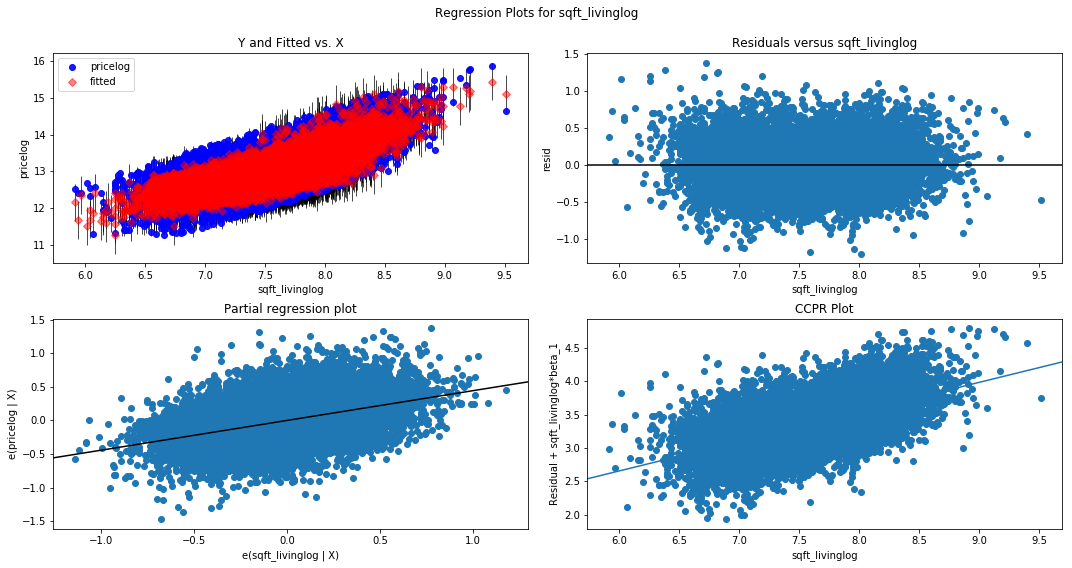

In [28]:
fig = plt.figure(figsize=(15,8))
fig = sm.graphics.plot_regress_exog(model5, "sqft_livinglog", fig=fig)
plt.show()

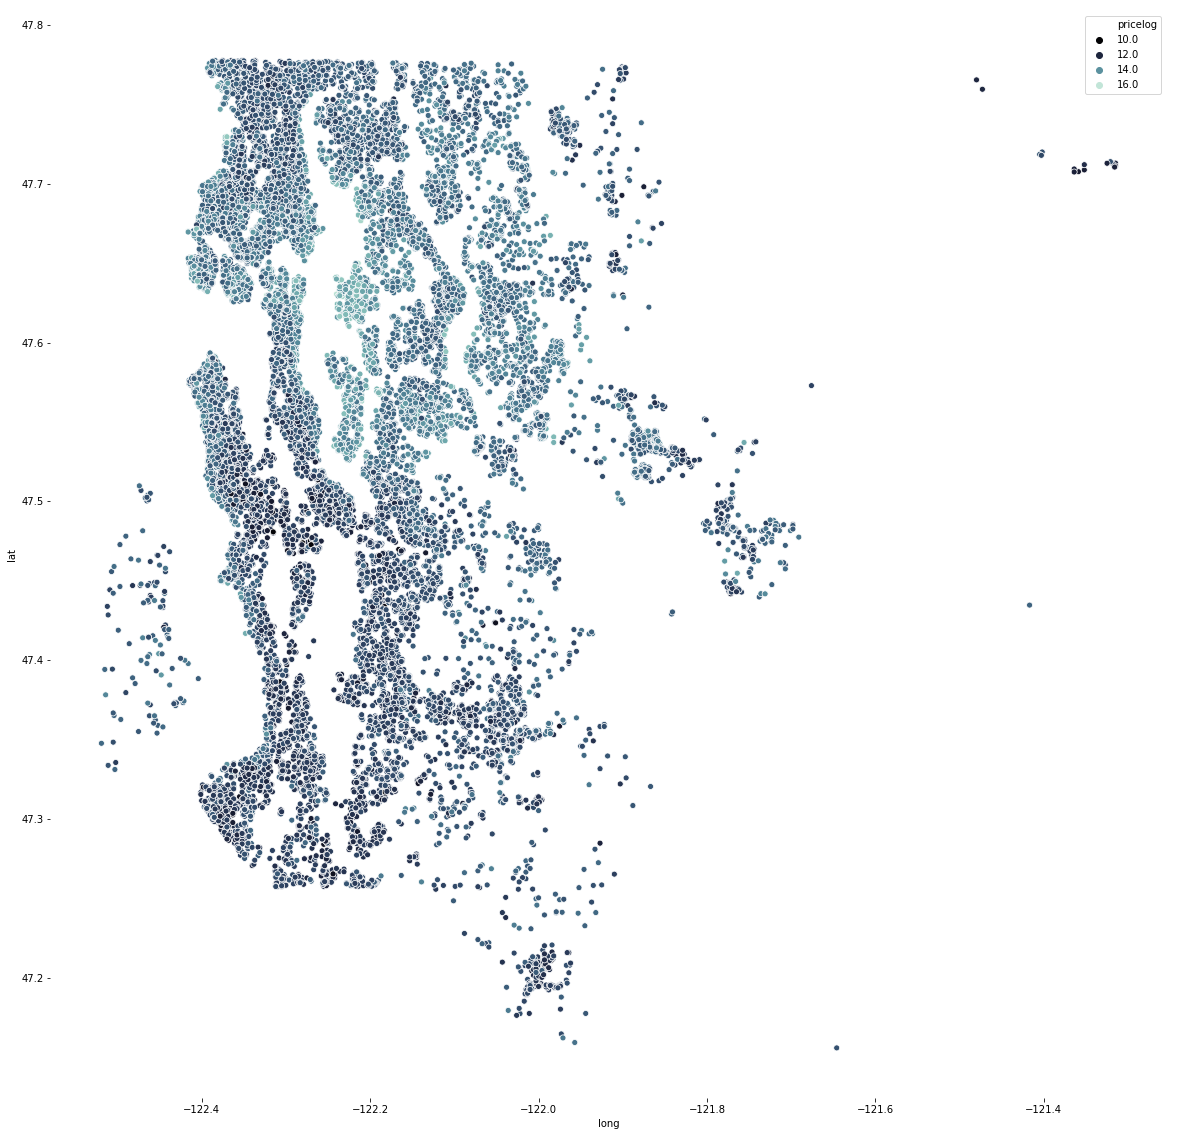

In [55]:
f, ax = plt.subplots(figsize=(20, 20))
sns.despine(f, left=True, bottom=True)
sns.scatterplot(x="long", y="lat",
                hue="pricelog",
                palette="ch:r=-.3,d=0.01_r",
                data=df, ax=ax)

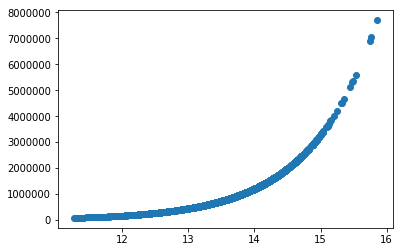

In [39]:
plt.scatter(df['pricelog'],df['price'])

In [20]:
df.yr_built.value_counts()

2014    547
2006    449
2005    442
2004    423
2003    410
1977    405
2007    404
1978    382
1968    370
2008    356
1967    340
1979    335
1959    330
1990    309
2001    303
1962    301
1954    297
1987    289
1989    280
1969    272
1988    264
1955    257
1999    257
1947    255
1963    248
1976    247
1950    245
1994    242
1960    242
1966    238
       ... 
1909     91
1906     91
1908     86
1930     85
1900     84
1923     81
1919     80
1916     79
1912     75
1921     73
1905     73
1911     73
1937     68
1915     63
1907     63
1931     59
1913     57
1917     55
1914     53
1938     52
1904     45
1903     42
1936     40
1932     37
2015     35
1933     30
1901     27
1902     27
1935     23
1934     20
Name: yr_built, Length: 116, dtype: int64